In [1]:
%matplotlib inline

In [2]:
import sys 
import os.path
sys.path += [os.path.abspath("../../")]

In [3]:
from lib import filedb
import pandas as pd
import numpy as np
from lib import strainmap
#from figures.figure_63x_sigb_histo import subfig_indivfile_histo
from lib.analysis.sigb_histograms import make_indivfile_histogram
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import scipy.stats

In [4]:
basedir = "/media/nmurphy/BF_Data_Orange/datasets/new_strain_snaps1/"
cell_df = pd.read_hdf(os.path.join(basedir, "single_cell_data.h5"), "cells")
file_df = filedb.get_filedb(os.path.join(basedir, "file_list.tsv"))

In [29]:
strain_to_type, type_to_strain = strainmap.load()
strain_to_type = {s:t[0] for s,t in strain_to_type.items() }

In [37]:
cell_types = np.unique([ t for t in strain_to_type.values()])

In [32]:
file_df["color"] = file_df["strain"].replace({s: i for i, s in enumerate(file_df["strain"].unique())})
file_df["type"] = file_df["strain"].replace(strain_to_type)

In [39]:
type_to_strain = dict(zip(cell_types, [[]]*len(cell_types)))
for strain, typel in strain_to_type.items():
    type_to_strain[typel] =  type_to_strain[typel] + [strain]

In [40]:
type_to_strain

{'2xqp_sigar_sigby': ['jlb095'],
 '2xqp_sspby': ['jlb117'],
 'delqp_sigar_sigby': ['jlb039'],
 'delqp_sspby': ['jlb127'],
 'delru_sigar_sigby': ['jlb088'],
 'delru_sspby': ['jlb129'],
 'delsigb_sigar_sigby': ['jlb098'],
 'delsigb_sspby': ['jlb118'],
 'delsigbx_sspby': ['jlb119'],
 'et2xqp_sigar_sigby': ['neb011', 'neb012'],
 'et_sigar_csbby': ['neb026', 'neb027'],
 'et_sigar_sigay': ['neb034'],
 'et_sigar_sigby': ['jlb106'],
 'et_sigar_yflay': ['neb024', 'neb025'],
 'etdelru_sigar_sigby': ['neb008', 'neb009'],
 'etdelsigf_sigar_sigby': ['neb018'],
 'rfponly_sigar': ['jlb035'],
 'wt_blank': ['jlb001'],
 'wt_sigar_sigby': ['jlb021'],
 'wt_sigby_spoiidc': ['jlb124'],
 'wt_sigby_sspbc': ['jlb109'],
 'wt_sighy_sigar': ['jlb024'],
 'wt_sspby': ['jlb077']}

In [5]:
cell_df.columns

Index(['image_row', 'image_col', 'distance', 'slice_row', 'slice_col',
       'segment_label', 'area', 'length', 'perimeter', 'eccentricity',
       'red_raw_std', 'red_raw_mean', 'red_raw_meannorm', 'red_raw_maxnorm',
       'green_raw_std', 'green_raw_mean', 'green_raw_meannorm',
       'green_raw_maxnorm', 'global_file_id'],
      dtype='object')

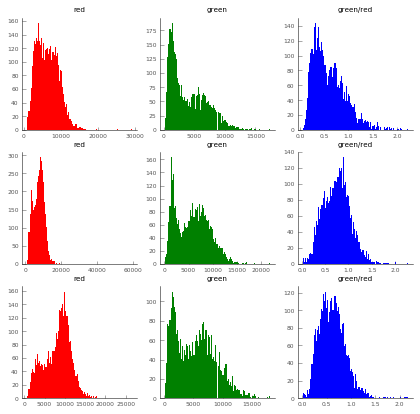

In [107]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(7,7)
for i, fid in enumerate(files):
    grn = cell_df.loc[cell_df["global_file_id"]==fid, "green_raw_mean"]
    red = cell_df.loc[cell_df["global_file_id"]==fid, "red_raw_mean"]
    ax[i, 0].hist(red, bins=100, color="red")
    ax[i, 1].hist(grn, bins=100, color="green")
    ax[i, 2].hist(grn/red, bins=100, color="blue")
    ax[i, 0].set_title("red")
    ax[i, 1].set_title("green")
    ax[i, 2].set_title("green/red")


fig.savefig("/tmp/raw_image_histograms.png")

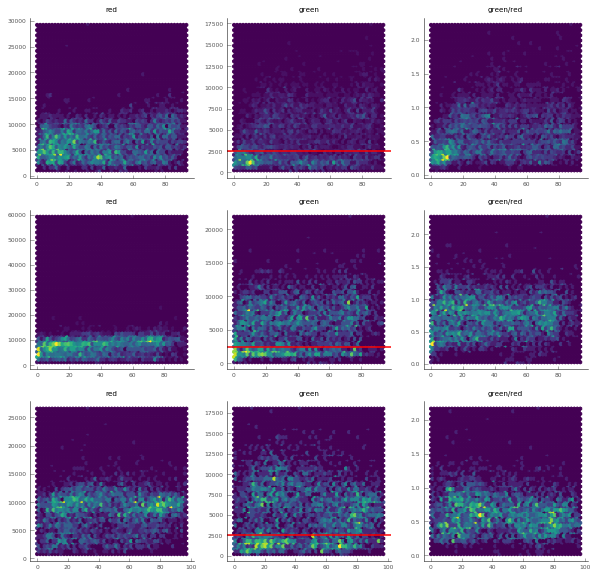

In [110]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(10,10)
for i, fid in enumerate(files):
    grn = cell_df.loc[cell_df["global_file_id"]==fid, "green_raw_mean"]
    red = cell_df.loc[cell_df["global_file_id"]==fid, "red_raw_mean"]
    distance = cell_df.loc[cell_df["global_file_id"]==fid, "distance"]
    ax[i, 0].hexbin(distance, red,   gridsize=50)
    ax[i, 1].hexbin(distance, grn,  gridsize=50)
    ax[i, 2].hexbin(distance, grn/red,   gridsize=50)
    ax[i, 1].axhline(2500, color="red")
    ax[i, 0].set_title("red")
    ax[i, 1].set_title("green")
    ax[i, 2].set_title("green/red")
fig.savefig("/tmp/bimod.png", layout="tight")

# Where are the low brightness (green) cells?

Are they sgementation errors? 

In [31]:
file_df

,path,name,dirname,time,location,strain
file_id,,,,,,
0,NaN,JLB088_48hrs_63x_1,Set_2/48hrs/63x,48.0,livedish,jlb088
1,NaN,JLB088_48hrs_63x_2,Set_2/48hrs/63x,48.0,livedish,jlb088
2,NaN,JLB088_48hrs_63x_3,Set_2/48hrs/63x,48.0,livedish,jlb088


In [33]:
import skimage.morphology

In [112]:
redb = 1.0
greenb = 1.0
based = "/media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images"

for i, fid in enumerate(files):
    red = skimage.io.imread("{0}/{1}/{2}/{2}_cr.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #     grn = skimage.io.imread("{0}/{1}/{2}/{2}_cg.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #im = np.dstack([red*redb, grn*grnb, np.zeros_list(grn)])
    blank = np.zeros_like(red)
    probcels = cell_df[(cell_df["global_file_id"] == fid) & (cell_df["green_raw_mean"]<2500)]
    blank[probcels["image_row"],probcels["image_col"]] = (2**16)-1
    blank = skimage.morphology.dilation(blank, selem=skimage.morphology.disk(3))
    skimage.io.imsave("{0}/{1}/{2}/{2}_debug.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]), blank)
    

/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images/Set_2/48hrs/63x/JLB088_48hrs_63x_2/JLB088_48hrs_63x_2_debug.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images/Set_2/48hrs/63x/JLB088_48hrs_63x_3/JLB088_48hrs_63x_3_debug.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


The bi-modol population has 2 origins,
- many cells seem to be in another plane but are segmented anyway. it seems that about 7000 red units is a good threshold. 
- sporeulating cells are segmented as 2 cells and the spore bit is quite dim


In [68]:
cell_df_filter = cell_df.loc[cell_df["red_raw_mean"] > 7000, :].copy()

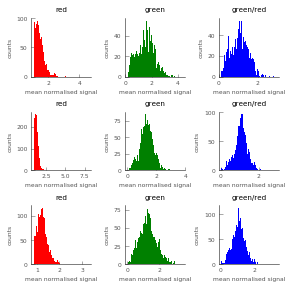

In [117]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(4,4)

for i, fid in enumerate(files):
    grn = cell_df_filter.loc[cell_df_filter["global_file_id"]==fid, "green_raw_meannorm"]
    red = cell_df_filter.loc[cell_df_filter["global_file_id"]==fid, "red_raw_meannorm"]
    ax[i, 0].hist(red, bins=100, color="red")
    ax[i, 1].hist(grn, bins=100, color="green")
    ax[i, 2].hist(grn/red, bins=100, color="blue")
    ax[i, 0].set_title("red")
    ax[i, 1].set_title("green")
    ax[i, 2].set_title("green/red")
    
for a in ax.flatten():
    a.set_ylabel("counts")
    a.set_xlabel("mean normalised signal")
    
fig.tight_layout()
fig.savefig("/tmp/new_histo.png")

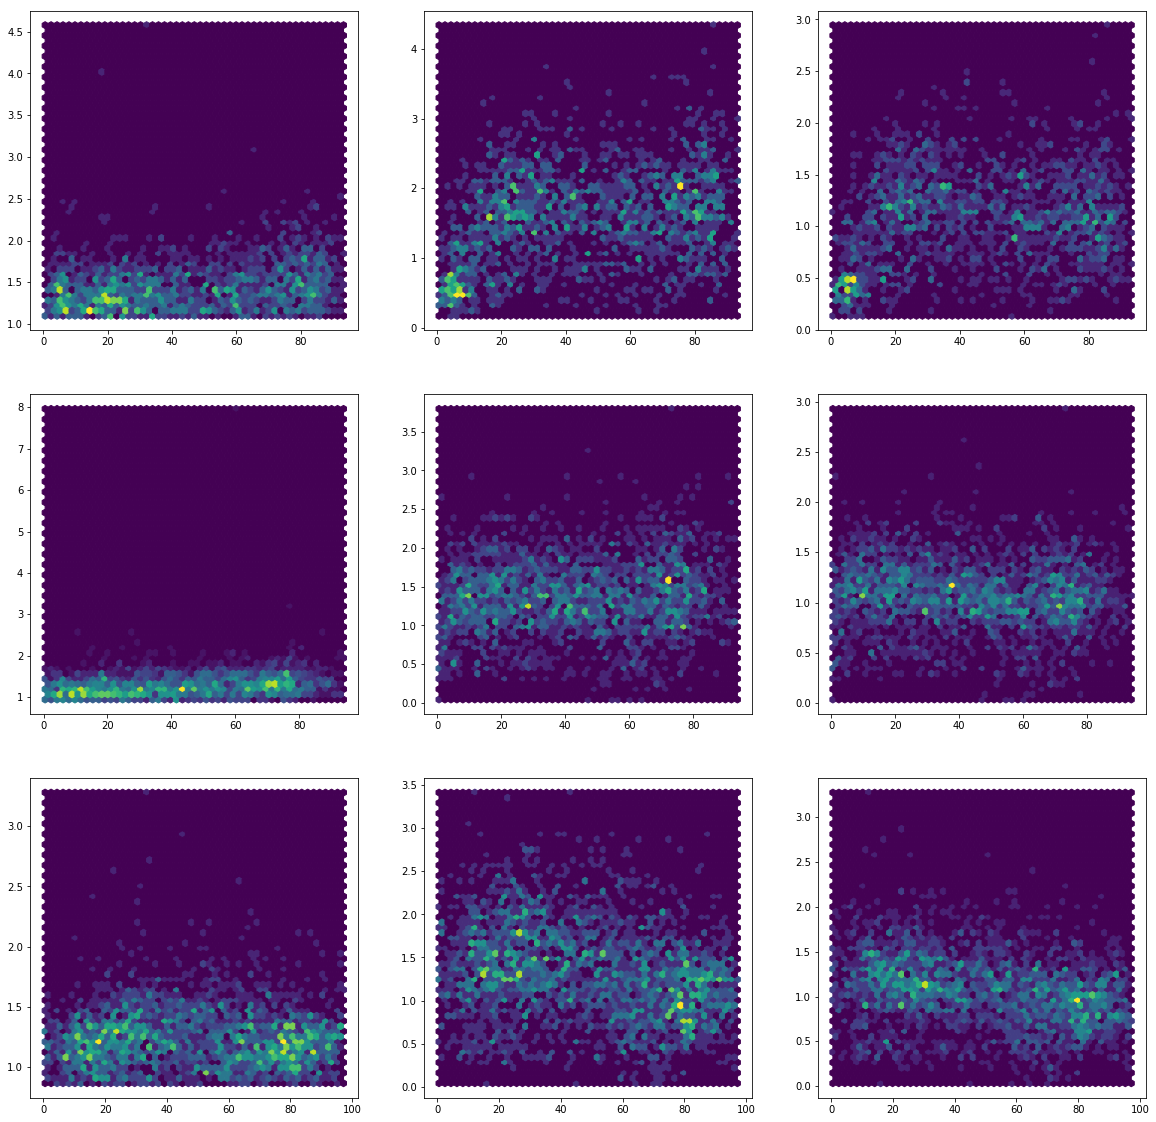

In [78]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(20,20)
for i, fid in enumerate(files):
    grn = cell_df_filter.loc[cell_df_filter["global_file_id"]==fid, "green_raw_meannorm"]
    red = cell_df_filter.loc[cell_df_filter["global_file_id"]==fid, "red_raw_meannorm"]
    distance = cell_df_filter.loc[cell_df_filter["global_file_id"]==fid, "distance"]
    ax[i, 0].hexbin(distance, red,   gridsize=50)
    ax[i, 1].hexbin(distance, grn,  gridsize=50)
    ax[i, 2].hexbin(distance, grn/red,   gridsize=50)
    #ax[i, 1].axhline(2500)

In [111]:
redb = 1.0
greenb = 1.0
based = "/media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images"

for i, fid in enumerate(files):
    red = skimage.io.imread("{0}/{1}/{2}/{2}_cr.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #     grn = skimage.io.imread("{0}/{1}/{2}/{2}_cg.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #im = np.dstack([red*redb, grn*grnb, np.zeros_list(grn)])
    blank = np.zeros_like(red)
    probcels = cell_df_filter[(cell_df_filter["global_file_id"] == fid) & (cell_df_filter["green_raw_mean"]<2500)]
    blank[probcels["image_row"],probcels["image_col"]] = (2**16)-1
    blank = skimage.morphology.dilation(blank, selem=skimage.morphology.disk(3))
    skimage.io.imsave("{0}/{1}/{2}/{2}_debug2.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]), blank)
    

/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images/Set_2/48hrs/63x/JLB088_48hrs_63x_1/JLB088_48hrs_63x_1_debug2.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images/Set_2/48hrs/63x/JLB088_48hrs_63x_2/JLB088_48hrs_63x_2_debug2.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images/Set_2/48hrs/63x/JLB088_48hrs_63x_3/JLB088_48hrs_63x_3_debug2.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


In [74]:
redb = 1.0
greenb = 1.0
based = "/media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images"

for i, fid in enumerate(files):
    red = skimage.io.imread("{0}/{1}/{2}/{2}_cr.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #     grn = skimage.io.imread("{0}/{1}/{2}/{2}_cg.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #im = np.dstack([red*redb, grn*grnb, np.zeros_list(grn)])
    blank = np.zeros_like(red)
    probcels = cell_df_filter[(cell_df_filter["global_file_id"] == fid)]
    blank[probcels["image_row"],probcels["image_col"]] = (2**16)-1
    blank = skimage.morphology.dilation(blank, selem=skimage.morphology.disk(3))
    skimage.io.imsave("{0}/{1}/{2}/{2}_debug3.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]), blank)
    

In [ ]:
What does the histogram  look like compared to the paper. 

In [79]:
sys.path += [os.path.realpath("../../figures/figure_63x_sigb_histo/")]
import subfig_indivfile_histo


In [96]:
max_val = 6.5 #2.5 
gmax_val = 6.5 #0.75
nbins = 150
rbins = (0, max_val, nbins)
gbins = (0, gmax_val, nbins)
slice_srt, slice_end = 5, 7 #10, 15
percentile=0

mean: 0.93
std: 0.38
CV: 0.41
Moment skew: 0.08
Kurtosis -0.71
Number of files: 3
Cells: 275
------------------------
mean: 0.77
std: 0.52
CV: 0.68
Moment skew: 0.76
Kurtosis -0.31
Number of files: 3
Cells: 275
------------------------


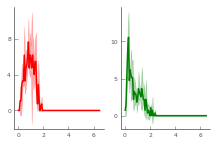

In [120]:
fids = file_df[(file_df["time"] == 48) &
                (file_df["strain"] == "jlb088")].index
strain_df = cell_df[cell_df["global_file_id"].isin(fids)]
#print(strain_df)
dset = 48, "center", "jlb088"
tbins = gbins
gchan="green_raw_meannorm"
rchan="red_raw_meannorm"

    
list_of_histos = [ 
        ("wt_sigar_sigby", rchan,   "ΔrsbRU P$_{sigA}$-RFP",      "red"),
        ("wt_sigar_sigby", gchan, "ΔrsbRU P$_{sigB}$-YFP",        "green")]

fig, axhisto = plt.subplots(1,len(list_of_histos))
fig.set_size_inches(3,2)
for i, (strain, chan, label, color) in enumerate(list_of_histos):

    if "red" in chan:
        tbins = rbins
    plot_args = {"color":color, "max_min":"std", "mode_mean": False}

    args = (axhisto[i], strain_df, chan, tbins, (slice_srt, slice_end), dset, percentile, False, ".", plot_args)
    axhisto[i], _, meandmed = subfig_indivfile_histo.get_figure(*args)
fig.tight_layout()
fig.savefig("/tmp/paper_hist.png")

# Load up the rest of the plots

In [6]:
strain_c = {s: i for i,s in enumerate(np.unique(file_df["strain"]))}
len(strain_c)

12

In [ ]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(6,20)
fig.set_dpi(80)
for i, fid in enumerate(files):
    grn = cell_df.loc[cell_df["global_file_id"]==fid, "green_raw_mean"]
    red = cell_df.loc[cell_df["global_file_id"]==fid, "red_raw_mean"]
    ax[i, 0].hist(red, bins=100, color="red")
    ax[i, 1].hist(grn, bins=100, color="green")
    ax[i, 2].hist(grn/red, bins=100, color="blue")

    ax[i, 0].set_ylabel(file_df.loc[fid, "strain"])
    strain = file_df.loc[fid, "strain"]
    ax[i, 0].set_xlim(0,30000)
    ax[i, 1].set_xlim(0,50000)
    ax[i, 2].set_xlim(0,5)
    color = plt.cm.tab10(strain_c[strain]/len(strain_c))
    for a in ax[i, :]:
        a.set_facecolor(color)
        a.set_ylim(0,300)
ax[0, 0].set_title("red")
ax[0, 1].set_title("green")
ax[0, 2].set_title("green/red")
    
fig.tight_layout()

/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


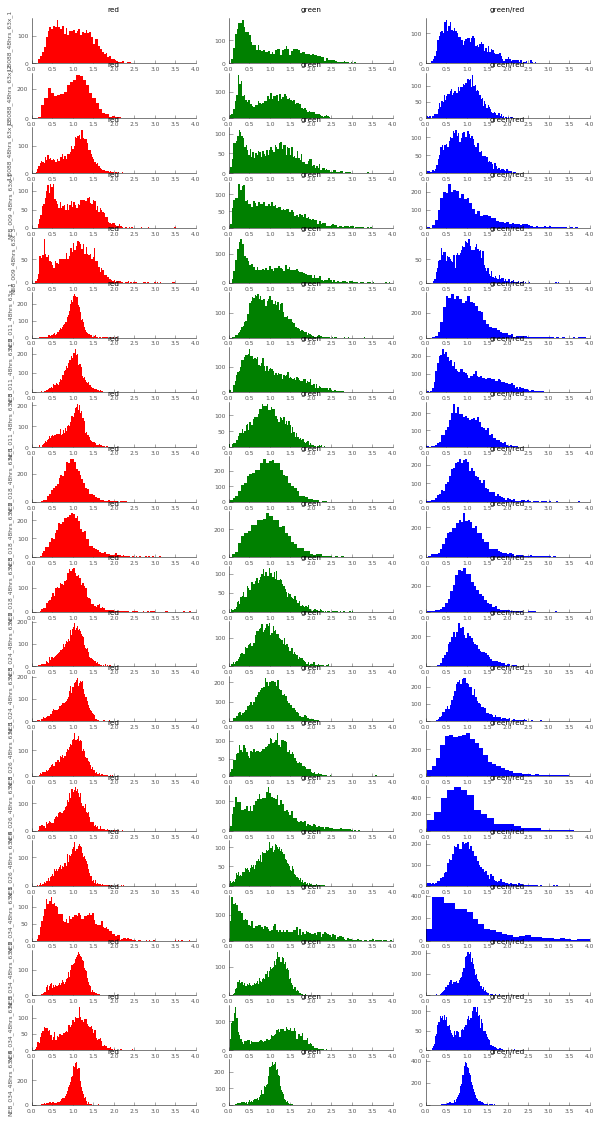

In [132]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(10,20)
for i, fid in enumerate(files):
    grn = cell_df.loc[cell_df["global_file_id"]==fid, "green_raw_meannorm"]
    red = cell_df.loc[cell_df["global_file_id"]==fid, "red_raw_meannorm"]
    ax[i, 0].hist(red, bins=100, color="red")
    ax[i, 1].hist(grn, bins=100, color="green")
    ax[i, 2].hist(grn/red, bins=100, color="blue")
    ax[i, 0].set_title("red")
    ax[i, 1].set_title("green")
    ax[i, 2].set_title("green/red")
    ax[i, 0].set_ylabel(file_df.loc[fid, "name"])
    
for a in ax.flatten():
    a.set_xlim(0, 4)

In [10]:
import scipy.stats

In [11]:
gamma_fit = scipy.stats.gamma.fit(cell_df["red_raw_mean"])

In [24]:
cell_df["red_raw_mean"].median()

9324.833333333334

In [60]:
gamma_fit = (21, -8400, 900)

In [61]:
18 * 1100

19800

In [62]:
x = np.arange(0, 30000)

In [63]:
y = scipy.stats.gamma.pdf(x, *gamma_fit)

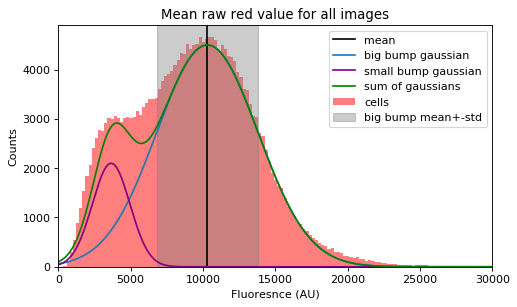

In [161]:
fig, ax = plt.subplots(1, 1)

ax = np.atleast_2d(ax)

fig.set_dpi(80)
fig.set_size_inches(7,4)
i = 0

ax[i, 0].hist(red, bins=300, color="red", label="cells", alpha=0.5)#, density=True)

x = np.arange(0, 30000)
mean = 10300
std = 3500
y = scipy.stats.norm.pdf(x, mean, std)
ax[i, 0].axvline(mean, color="black", label="mean")
ax[i, 0].axvspan(mean-std, mean+std,  color='grey', alpha=0.4, label="big bump mean+-std")

#maxp = 0.00009
maxp = 4500 # max point for scaling

y *= maxp/y.max()
ax[i, 0].plot(x, y, label="big bump gaussian")


x = np.arange(0, 30000)
ys = scipy.stats.norm.pdf(x, 3650, 1300)
#maxp = 0.000045
maxp = 2100

ys *= maxp/ys.max()
ax[i, 0].plot(x, ys, label="small bump gaussian", color="purple")

ax[i, 0].plot(x, y+ys,  label="sum of gaussians", color="green")

ax[i, 0].set_title("Mean raw red value for all images")
ax[i,0].set_xlabel("Fluoresnce (AU)")
ax[i,0].set_ylabel("Counts")

ax[i, 0].set_xlim(0, 30000)
    
ax[i, 0].legend()
fig.savefig("/tmp/removing_strange_cells1.png")

In [7]:
def is_a_good_cell(v, mean = 10300, std = 3500):
    if (v < mean + std) & (v > mean - std):
        return True
    else:
        return False

In [8]:
cell_df_filter = cell_df.loc[cell_df["red_raw_mean"].apply(is_a_good_cell), :]

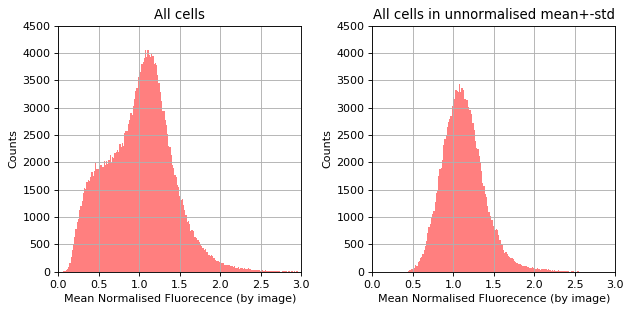

In [9]:
fig, ax = plt.subplots(1, 2)
fig.set_dpi(80)
fig.set_size_inches(8,4)
cell_df["red_raw_meannorm"].hist(bins=np.linspace(0, 3.0, 200), ax=ax[0], color="red", alpha=0.5)
cell_df_filter["red_raw_meannorm"].hist(bins=np.linspace(0, 3.0, 200), ax=ax[1], color="red", alpha=0.5)
for a in ax:
    a.set_xlim(0, 3.0)
    a.set_ylim(0, 4500)
    a.set_xlabel("Mean Normalised Fluorecence (by image)")
    a.set_ylabel("Counts")
    
ax[0].set_title("All cells")
ax[1].set_title("All cells in unnormalised mean+-std")
fig.tight_layout()
fig.savefig("/tmp/removing_strange_cells2.png")

### RFP vs YFP 

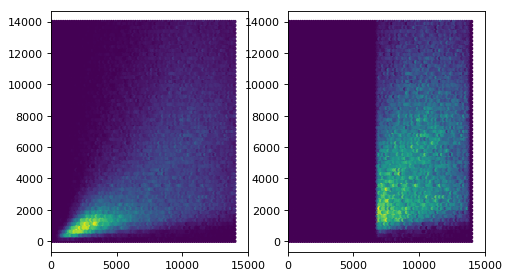

In [10]:
fig, ax = plt.subplots(1, 2)

ax = np.atleast_2d(ax)

fig.set_dpi(80)
fig.set_size_inches(7,4)
i = 0

ax[i, 0].hexbin(cell_df["red_raw_mean"], cell_df["green_raw_mean"],  label="cells", extent=(0, 14000, 0, 14000))#, density=True)

ax[i, 1].hexbin(cell_df_filter["red_raw_mean"], cell_df_filter["green_raw_mean"], extent=(0, 14000, 0, 14000), label="cells")#, density=True)

# x = np.arange(0, 30000)
# mean = 10300
# std = 3500
# y = scipy.stats.norm.pdf(x, mean, std)
# ax[i, 0].axvline(mean, color="black", label="mean")
# ax[i, 0].axvspan(mean-std, mean+std,  color='grey', alpha=0.4, label="big bump mean+-std")

# #maxp = 0.00009
# maxp = 4500 # max point for scaling

# y *= maxp/y.max()
# ax[i, 0].plot(x, y, label="big bump gaussian")


# x = np.arange(0, 30000)
# ys = scipy.stats.norm.pdf(x, 3650, 1300)
# #maxp = 0.000045
# maxp = 2100

# ys *= maxp/ys.max()
# ax[i, 0].plot(x, ys, label="small bump gaussian", color="purple")

# ax[i, 0].plot(x, y+ys,  label="sum of gaussians", color="green")

# ax[i, 0].set_title("Mean raw red value for all images")
# ax[i,0].set_xlabel("Fluoresnce (AU)")
# ax[i,0].set_ylabel("Counts")

for a in ax.flatten():
    a.set_xlim(0, 15000)
    
# ax[i, 0].legend()
# fig.savefig("/tmp/removing_strange_cells1.png")

# Look at cell type by cell type

In [366]:
# strain_to_type

In [282]:
delfstrain = sum([type_to_strain[t] for t in ["etdelsigf_sigar_sigby"] ], [])
delf_groups = file_df[file_df["strain"].isin(delfstrain)].groupby(["time", "type"]).groups

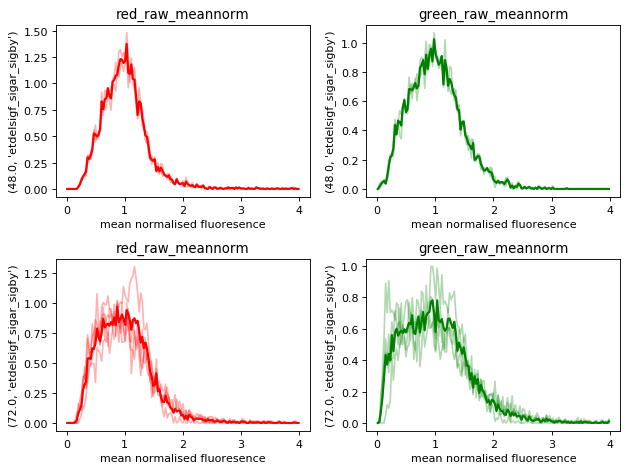

In [283]:
fig, ax = plt.subplots(len(delf_groups), 2)
fig.set_size_inches(8,6)
fig.set_dpi(80)

max_val = 4 #2.5 
nbins = 150
rbins = (0, max_val, nbins)
channels = [("red_raw_meannorm", "red"), ("green_raw_meannorm", "green")]

plot_indiv_files(cell_df, channels, delf_groups, rbins, ax )
fig.tight_layout()

In [337]:
import scipy.stats

In [344]:

def plot_indiv_files(cell_df, channels, groups, ax ):

    for i, group in enumerate(groups):
        fids = groups[group]
        strain_df = cell_df.loc[cell_df["global_file_id"].isin(fids), :]

        for c, (channel, color, bins) in enumerate(channels):
            for fid in fids:
                y, x = np.histogram(strain_df.loc[strain_df["global_file_id"]==fid, channel], bins = np.linspace(*bins), density=True)
                x = x[1:]-((x[1] - x[0])/2)
                ax[i, c].plot(x, y, color=color, alpha=0.3)

            y, x = np.histogram(strain_df[channel], bins = np.linspace(*bins), density=True)
            x = x[1:]-((x[1] - x[0])/2)
            cv = scipy.stats.variation(strain_df[channel])
            ax[i, c].plot(x, y, color=color, alpha=1.0, linewidth=2.0)
            ax[i, c].text(x=0.8, y=0.8, s="CV={0:0.03f}".format(cv), ha="right", va="top", transform=ax[i, c].transAxes)
            ax[i, c].set_ylabel(group)
            ax[i,c].set_title(channel)
            ax[i,c].set_xlabel("mean normalised fluoresence")
    return ax

In [340]:

nbins = 150
rbins = (0, max_val, nbins)
#gbins = (0, gmax_val, nbins)

max_val = 4 #2.5 
nbins = 150
rbins = (0, max_val, nbins)
abins = (0, 40000, nbins)
channels = [("red_raw_meannorm", "red", rbins), ("green_raw_meannorm", "green", rbins), ("green_raw_mean", "green",abins)]


# delRU

In [187]:
delru_types = ["delru_sigar_sigby", "etdelru_sigar_sigby"]

In [188]:
delru_strains = sum([type_to_strain[t] for t in delru_types ], [])

In [300]:
delru_strains

['jlb088', 'neb008', 'neb009']

In [195]:
delru_images = file_df[file_df["strain"].isin(delru_strains)].index

In [273]:
delru_groups = file_df[file_df["strain"].isin(delru_strains)].groupby(["time", "type"]).groups

/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


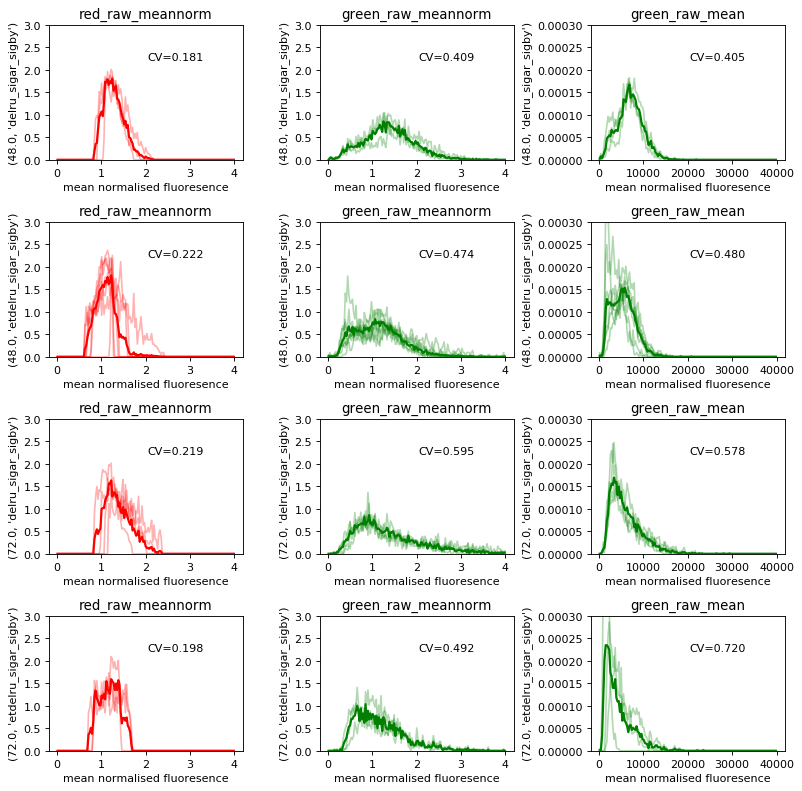

In [345]:
fig, ax = plt.subplots(len(delru_groups), 3)
fig.set_size_inches(10,10)
fig.set_dpi(80)


ax = plot_indiv_files(cell_df_filter, channels, delru_groups, ax )
for a in ax[:,:2].flatten():
    a.set_ylim(0, 3.0)
for a in ax[:,2].flatten():
    a.set_ylim(0, 0.0003)
fig.tight_layout()
fig.savefig("/tmp/delRU.png")

# 2xQP

In [240]:
QPx2strain = sum([type_to_strain[t] for t in ["et2xqp_sigar_sigby"] ], [])

In [299]:
QPx2strain

['neb011', 'neb012']

In [243]:
QPx2_groups = file_df[file_df["strain"].isin(QPx2strain)].groupby(["time", "type"]).groups

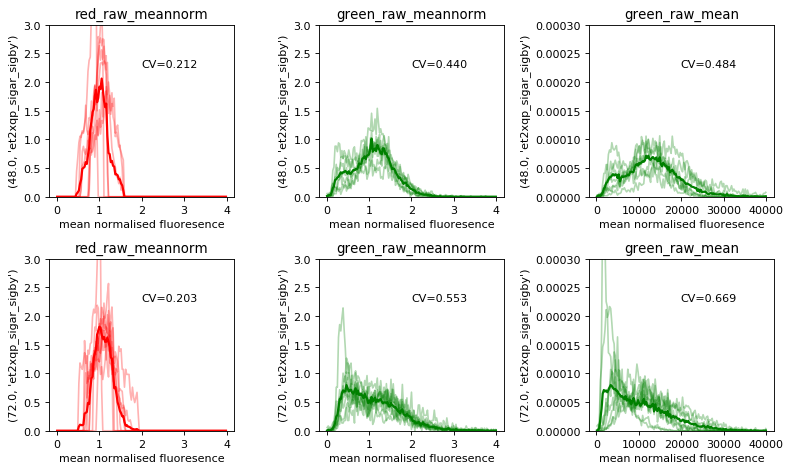

In [349]:
fig, ax = plt.subplots(len(QPx2_groups), 3)
fig.set_size_inches(10,6)
fig.set_dpi(80)


ax = plot_indiv_files(cell_df_filter, channels, QPx2_groups, ax )
for a in ax[:,:2].flatten():
    a.set_ylim(0, 3.0)
for a in ax[:,2].flatten():
    a.set_ylim(0, 0.0003)
fig.tight_layout()
fig.savefig("/tmp/2xQP.png")

# CSBB

In [296]:
csbbystrain = sum([type_to_strain[t] for t in ["et_sigar_csbby"] ], [])
csbby_groups = file_df[file_df["strain"].isin(csbbystrain)].groupby(["time", "type"]).groups

In [298]:
csbbystrain

['neb026', 'neb027']

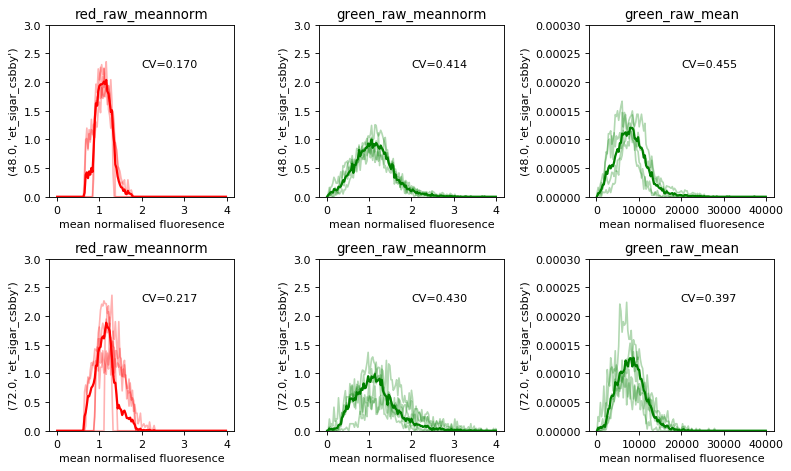

In [352]:
fig, ax = plt.subplots(len(csbby_groups), 3)
fig.set_size_inches(10,6)
fig.set_dpi(80)

ax = plot_indiv_files(cell_df_filter, channels, csbby_groups, ax )
for a in ax[:,:2].flatten():
    a.set_ylim(0, 3.0)
for a in ax[:,2].flatten():
    a.set_ylim(0, 0.0003)
fig.tight_layout()
fig.savefig("/tmp/CSBB.png")

# DelRUDelsigF

In [282]:
delfstrain = sum([type_to_strain[t] for t in ["etdelsigf_sigar_sigby"] ], [])
delf_groups = file_df[file_df["strain"].isin(delfstrain)].groupby(["time", "type"]).groups

In [301]:
delfstrain

['neb018']

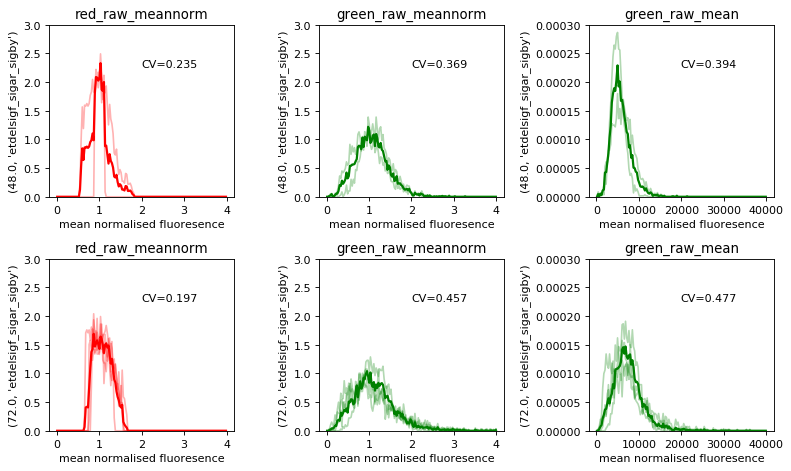

In [353]:
fig, ax = plt.subplots(len(delf_groups), 3)
fig.set_size_inches(10,6)
fig.set_dpi(80)

ax = plot_indiv_files(cell_df_filter, channels, delf_groups,  ax )
for a in ax[:,:2].flatten():
    a.set_ylim(0, 3.0)
for a in ax[:,2].flatten():
    a.set_ylim(0, 0.0003)
fig.tight_layout()
fig.savefig("/tmp/dsigF.png")

# flay

In [286]:
flaystrain = sum([type_to_strain[t] for t in ["et_sigar_yflay"] ], [])
flay_groups = file_df[file_df["strain"].isin(flaystrain)].groupby(["time", "type"]).groups

In [303]:
flaystrain

['neb024', 'neb025']

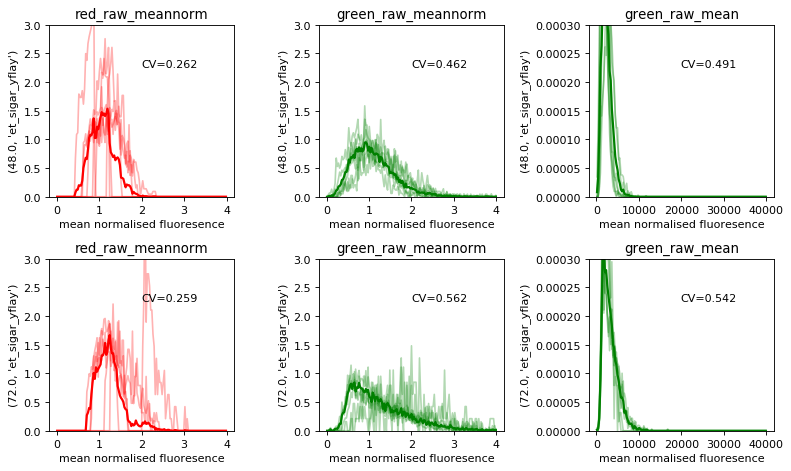

In [354]:
fig, ax = plt.subplots(len(flay_groups), 3)
fig.set_size_inches(10,6)
fig.set_dpi(80)


ax = plot_indiv_files(cell_df_filter, channels, flay_groups, ax )
for a in ax[:,:2].flatten():
    a.set_ylim(0, 3.0)
for a in ax[:,2].flatten():
    a.set_ylim(0, 0.0003)
fig.tight_layout()
fig.savefig("/tmp/dfla.png")

# Sig A red SigA yellow

In [289]:
sigystrain = sum([type_to_strain[t] for t in ["et_sigar_sigay"] ], [])
sigay_groups = file_df[file_df["strain"].isin(sigystrain)].groupby(["time", "type"]).groups

In [305]:
sigystrain

['neb034']

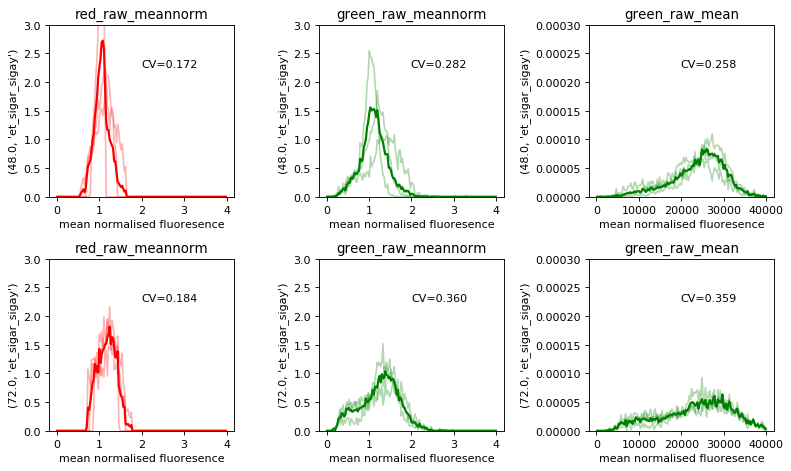

In [355]:
fig, ax = plt.subplots(len(sigay_groups), 3)
fig.set_size_inches(10,6)
fig.set_dpi(80)

ax = plot_indiv_files(cell_df_filter, channels, sigay_groups, ax )
for a in ax[:,:2].flatten():
    a.set_ylim(0, 3.0)
for a in ax[:,2].flatten():
    a.set_ylim(0, 0.0003)
fig.tight_layout()
fig.savefig("/tmp/sigay.png")

# New wild Type

In [292]:
newwt_strain = sum([type_to_strain[t] for t in ["et_sigar_sigby"] ], [])
newwt_groups = file_df[file_df["strain"].isin(newwt_strain)].groupby(["time", "type"]).groups

In [307]:
newwt_strain

['jlb106']

/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


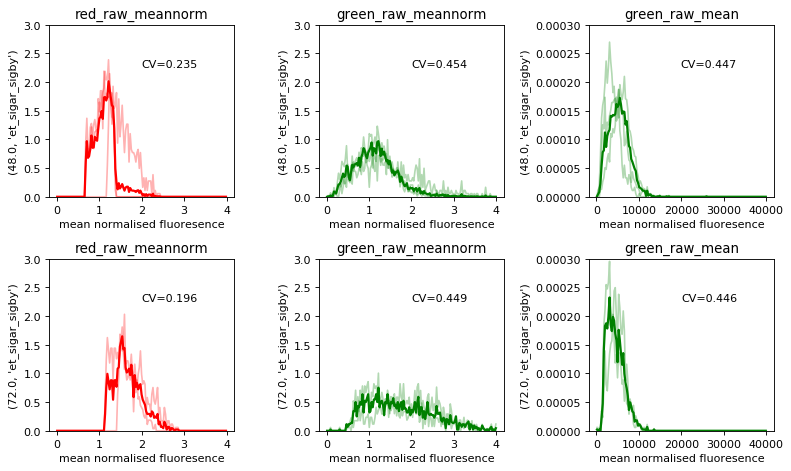

In [356]:
fig, ax = plt.subplots(len(newwt_groups), 3)
fig.set_size_inches(10,6)
fig.set_dpi(80)


ax = plot_indiv_files(cell_df_filter, channels, newwt_groups, ax )
for a in ax[:,:2].flatten():
    a.set_ylim(0, 3.0)
for a in ax[:,2].flatten():
    a.set_ylim(0, 0.0003)
fig.tight_layout()
fig.savefig("/tmp/newwt.png")

# Gradients

In [465]:
gradients = pd.read_hdf("/media/nmurphy/BF_Data_Orange/datasets/lsm700_live20x_newstrain1/gradient_data_distmap.h5")
filedb_grad = file_df = filedb.get_filedb("/media/nmurphy/BF_Data_Orange/datasets/lsm700_live20x_newstrain1/file_list.tsv")

In [466]:
filedb_grad.head()

,path,name,dirname,time,location,strain
file_id,,,,,,
0,NaN,JLB106_48hrs_20x_1,Set_1/48hrs,48.0,livedish,jlb106
1,NaN,JLB106_48hrs_20x_2,Set_1/48hrs,48.0,livedish,jlb106
2,NaN,JLB106_48hrs_20x_3,Set_1/48hrs,48.0,livedish,jlb106
3,NaN,NEB008_48hrs_20x_1,Set_1/48hrs,48.0,livedish,neb008
4,NaN,NEB008_48hrs_20x_2,Set_1/48hrs,48.0,livedish,neb008


In [423]:
filedb_grad.shape

(76, 6)

In [424]:
gradients.head()

,cdist,pixels,red_raw_mean,red_raw_std,green_raw_mean,green_raw_std,file_id
0,0.25,4751,7229.324353,2764.019022,5227.275521,3370.343759,0
1,0.50,8003,7576.515807,2923.439799,5437.702237,3469.936455,0
2,0.75,6520,8489.233896,3278.869055,5935.314571,3610.064394,0
3,1.00,5700,9202.015965,3599.129624,6300.746842,3723.033378,0
4,1.25,4659,9686.121700,3951.986561,6565.748229,3888.359534,0


## Plot gradients 

In [483]:
def plot_gradients(type_name):
    fig, ax = plt.subplots(2, 3)
    fig.set_size_inches(12,5)
    fig.set_dpi(80)

    all_strains = type_to_strain[type_name]

    for s, time in enumerate([ 48.0, 72.0]): 
        fids = filedb_grad.loc[filedb_grad["strain"].isin(all_strains) & (filedb_grad["time"]==time)].index.unique()
        print(fids)
        for fid in fids:
            df = gradients.loc[gradients["file_id"] == fid, :]
            #df = df[df["cdist"]>2.0]
            df_mean = df.groupby("cdist").mean()
            #print(df_mean)
            ax[s, 0].plot(df_mean.index, df_mean["red_raw_mean"].values, label=fid)
            ax[s, 1].plot(df_mean.index, df_mean["green_raw_mean"].values, label=fid)
            ax[s, 2].plot(df_mean.index, df_mean["green_raw_mean"].values/df_mean["red_raw_mean"].values, label=fid)
            ax[s,0].set_ylabel(time)
        #ax[s, 1].text(x=0.5, y=0.9, s=strain_to_type[strain], ha="center", va="top", transform=ax[s, 1].transAxes)

    for a in ax.flatten():
        a.set_xlim(0, 400)
    for a in ax[:,0]:
        a.set_ylim(0, 60000)
    for a in ax[:,1]:
        a.set_ylim(0, 30000)
    for a in ax[:,2]:
        a.set_ylim(0, 2.0)

    #ax[0, 0].text(x=0.5, y=1.1, s="RFP raw", ha="center", va="bottom", transform=ax[0, 0].transAxes)
    # ax[0, 1].text(x=0.5, y=1.1, s="YFP raw", ha="center", va="bottom", transform=ax[0, 1].transAxes)
    # ax[0, 2].text(x=0.5, y=1.1, s="YFP/RFP ratio", ha="center", va="bottom", transform=ax[0, 2].transAxes)
    ax[0,1].set_title("YFP")
    ax[0,0].set_title("RFP")
    ax[0,2].set_title("YFP/RFP")

    ax[0,0].legend()
    ax[1,0].legend()


    fig.tight_layout()
    fig.savefig("/tmp/"+ type_name + "_gradients.png")
    return fig, ax

### delru_sigar_sigby

Int64Index([21, 22, 23], dtype='int64', name='file_id')
Int64Index([56, 57, 58], dtype='int64', name='file_id')


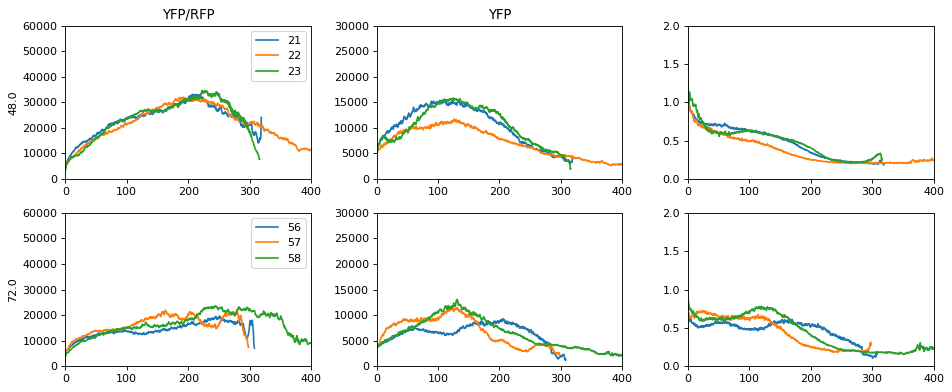

In [482]:
plot_gradients("delru_sigar_sigby");

Int64Index([3, 4, 5, 6, 7, 8, 24, 25, 26, 27], dtype='int64', name='file_id')
Int64Index([44, 45, 59, 60, 61], dtype='int64', name='file_id')


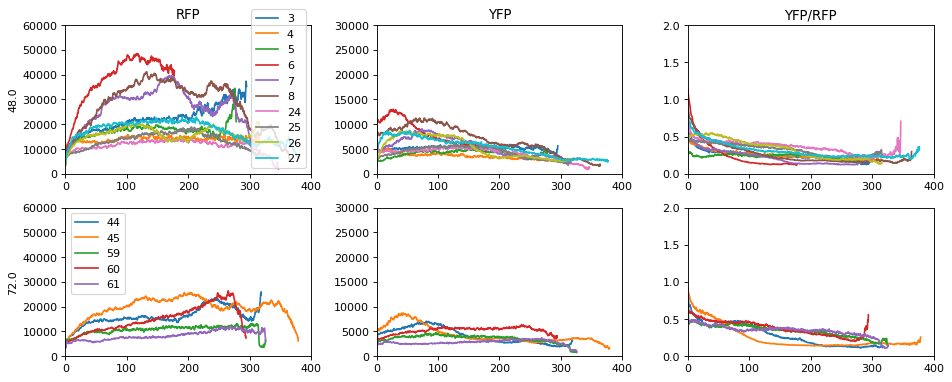

In [484]:
plot_gradients("etdelru_sigar_sigby");

### et2xqp_sigar_sigby

Int64Index([9, 10, 11, 12, 13, 14, 28, 29, 30], dtype='int64', name='file_id')
Int64Index([46, 47, 48, 49, 62, 63, 64], dtype='int64', name='file_id')


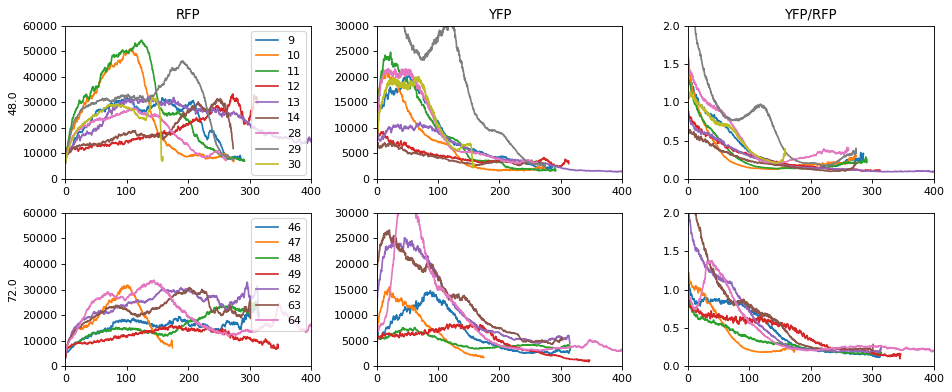

In [485]:
plot_gradients("et2xqp_sigar_sigby");

In [471]:
fid = 29
print("filename=\"" + filedb_grad.loc[fid]["name"] + "\"")
print("subset=\"" + filedb_grad.loc[fid]["dirname"] + "\"")

filename="NEB_011_48hrs_20x_2"
subset="Set_2/48hrs"


### et_sigar_sigay

Int64Index([40, 41, 42], dtype='int64', name='file_id')
Int64Index([75, 76, 77], dtype='int64', name='file_id')


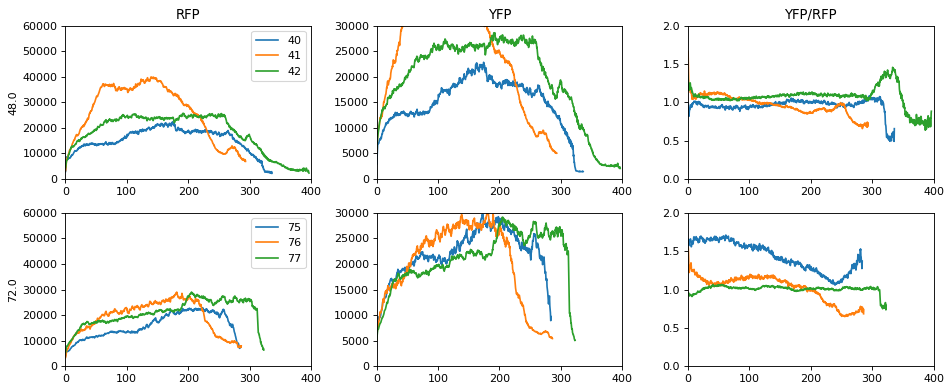

In [486]:
plot_gradients("et_sigar_sigay");

In [475]:
fid = 75
print("filename=\"" + filedb_grad.loc[fid]["name"] + "\"")
print("subset=\"" + filedb_grad.loc[fid]["dirname"] + "\"")

filename="NEB034_72hrs_20x_1"
subset="Set_2/72hrs"


### et_sigar_sigby

Int64Index([0, 1, 2], dtype='int64', name='file_id')
Int64Index([43], dtype='int64', name='file_id')


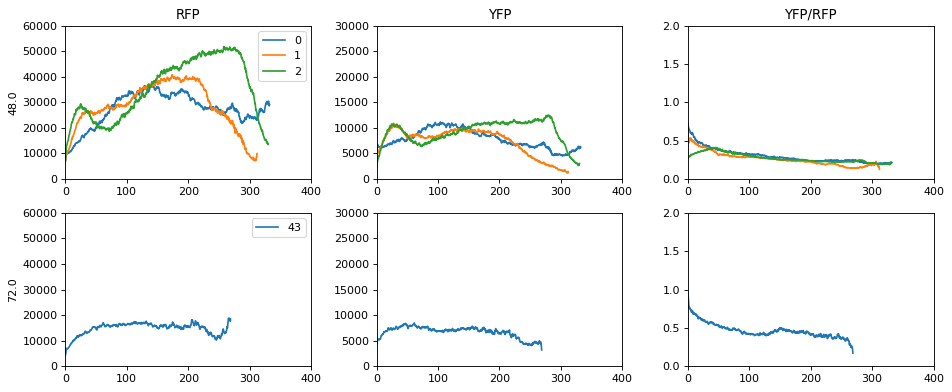

In [487]:
plot_gradients("et_sigar_sigby");

### etdelsigf_sigar_sigby

Int64Index([31, 32, 33], dtype='int64', name='file_id')
Int64Index([65, 66, 67], dtype='int64', name='file_id')


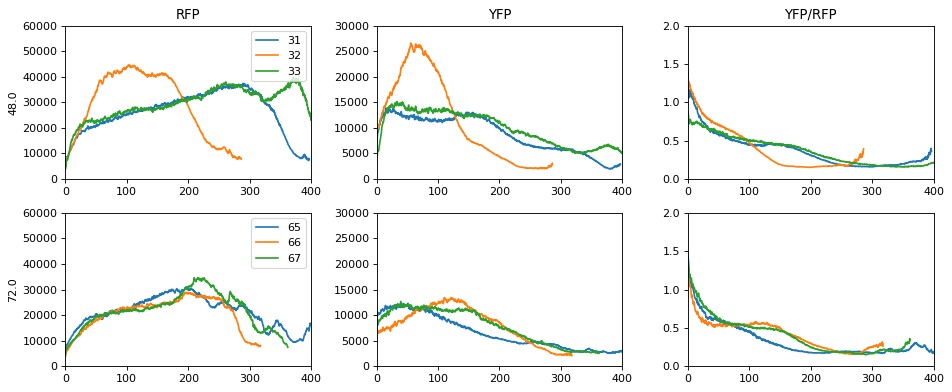

In [488]:
plot_gradients("etdelsigf_sigar_sigby");

In [478]:
fid = 32
print("filename=\"" + filedb_grad.loc[fid]["name"] + "\"")
print("subset=\"" + filedb_grad.loc[fid]["dirname"] + "\"")

filename="NEB_018_48hrs_20x_2"
subset="Set_2/48hrs"


### et_sigar_csbby

Int64Index([19, 20, 37, 38, 39], dtype='int64', name='file_id')
Int64Index([54, 55, 72, 73, 74], dtype='int64', name='file_id')


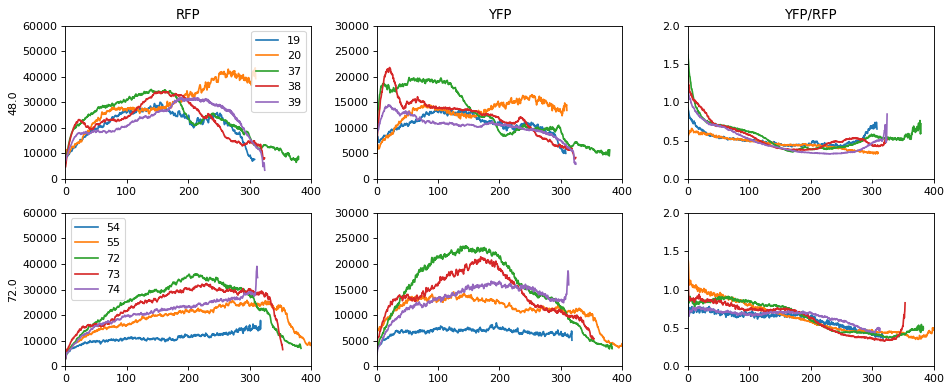

In [489]:
plot_gradients("et_sigar_csbby");

### et_sigar_yflay

Int64Index([15, 16, 18, 34, 35, 36], dtype='int64', name='file_id')
Int64Index([50, 51, 52, 68, 69, 70, 71], dtype='int64', name='file_id')


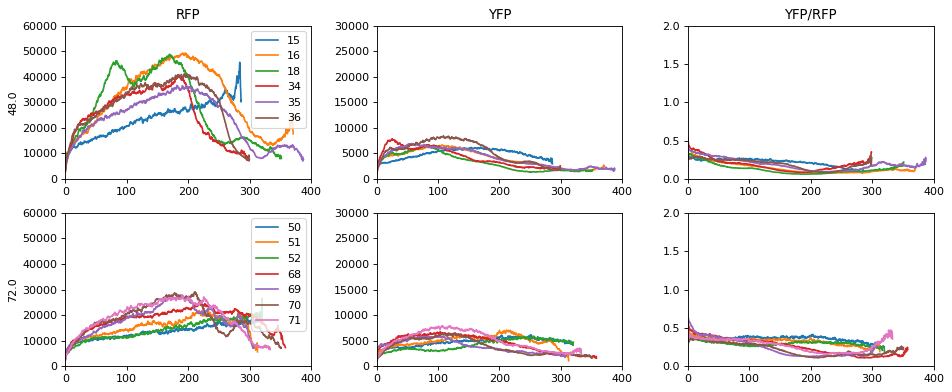

In [490]:
plot_gradients("et_sigar_yflay");

# YFP vs RFP

#### Sig A vs Sig A

In [42]:
sigavsiga = file_df[(file_df["strain"].isin(type_to_strain["et_sigar_sigay"]) & (file_df["time"]==48.0))]
sigavsiga

,path,name,dirname,time,location,strain,color,type
file_id,,,,,,,,
19,NaN,NEB_034_48hrs_63x_2,Set_2/48hrs/63x,48.0,livedish,neb034,6,et_sigar_sigay
20,NaN,NEB_034_48hrs_63x_3,Set_2/48hrs/63x,48.0,livedish,neb034,6,et_sigar_sigay
21,NaN,NEB_034_48hrs_63x_4,Set_2/48hrs/63x,48.0,livedish,neb034,6,et_sigar_sigay


In [43]:

strain_df = cell_df_filter.loc[cell_df_filter["global_file_id"].isin(sigavsiga.index), :]


In [44]:
strain_df.columns

Index(['image_row', 'image_col', 'distance', 'slice_row', 'slice_col',
       'segment_label', 'area', 'length', 'perimeter', 'eccentricity',
       'red_raw_std', 'red_raw_mean', 'red_raw_meannorm', 'red_raw_maxnorm',
       'green_raw_std', 'green_raw_mean', 'green_raw_meannorm',
       'green_raw_maxnorm', 'global_file_id'],
      dtype='object')

(0, 4)

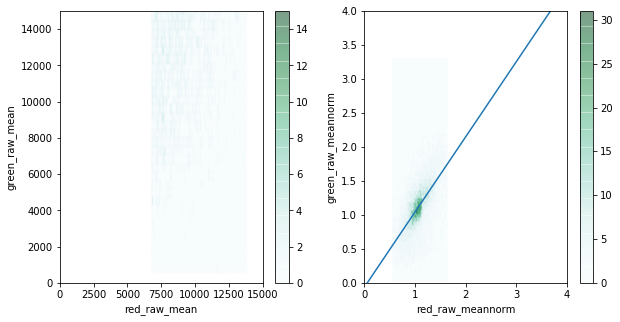

In [45]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)
strain_df.plot.hexbin(x="red_raw_mean", y="green_raw_mean",alpha=0.3, ax=ax[0])
strain_df.plot.hexbin(x="red_raw_meannorm", y="green_raw_meannorm", alpha=0.3, ax=ax[1])
fit = np.polyfit(strain_df["red_raw_meannorm"], strain_df["green_raw_meannorm"], 1)
polyf = np.poly1d(fit)
xp = np.linspace(0, 4, 100)
ax[1].plot(xp, polyf(xp))
ax[0].set_xlim(0, 15000)
ax[0].set_ylim(0, 15000)

ax[1].set_xlim(0, 4)
ax[1].set_ylim(0, 4)

In [46]:
sigavsigb = file_df[(file_df["strain"].isin(type_to_strain["et_sigar_sigby"]) & (file_df["time"]==48.0))]
sigavsigb

,path,name,dirname,time,location,strain,color,type
file_id,,,,,,,,
22,NaN,JLB106_48hrs_63x_1,Set_1/48hrs/63x,48.0,livedish,jlb106,7,et_sigar_sigby
23,NaN,JLB106_48hrs_63x_2,Set_1/48hrs/63x,48.0,livedish,jlb106,7,et_sigar_sigby
24,NaN,JLB106_48hrs_63x_3,Set_1/48hrs/63x,48.0,livedish,jlb106,7,et_sigar_sigby


In [47]:
strain_df = cell_df_filter.loc[cell_df_filter["global_file_id"].isin(sigavsigb.index), :]

(0, 4)

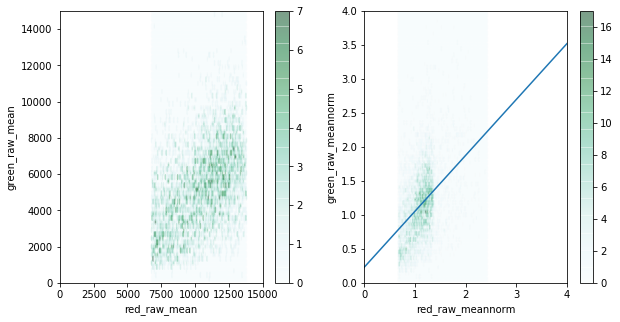

In [48]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)
strain_df.plot.hexbin(x="red_raw_mean", y="green_raw_mean",alpha=0.3, ax=ax[0])
strain_df.plot.hexbin(x="red_raw_meannorm", y="green_raw_meannorm", alpha=0.3, ax=ax[1])
fit = np.polyfit(strain_df["red_raw_meannorm"], strain_df["green_raw_meannorm"], 1)
polyf = np.poly1d(fit)
xp = np.linspace(0, 4, 100)
ax[1].plot(xp, polyf(xp))
ax[0].set_xlim(0, 15000)
ax[0].set_ylim(0, 15000)

ax[1].set_xlim(0, 4)
ax[1].set_ylim(0, 4)

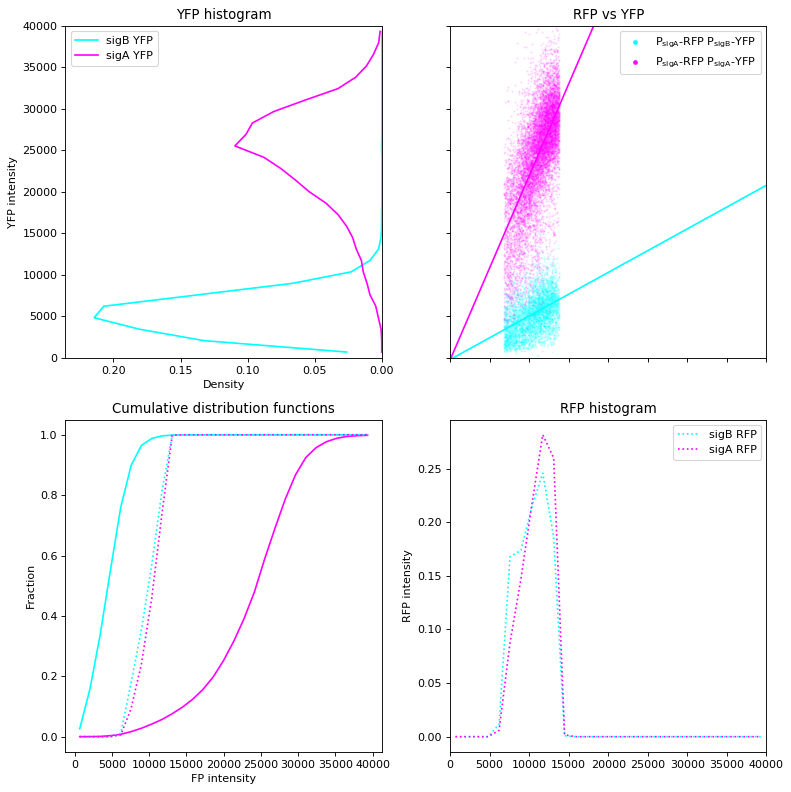

In [51]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(10, 10)
fig.set_dpi(80)
ax[0,0].get_shared_y_axes().join(ax[0,0], ax[0,1])
ax[0,1].get_shared_x_axes().join(ax[0,1], ax[1,1])


strain_sigby = cell_df_filter.loc[cell_df_filter["global_file_id"].isin(sigavsigb.index), :]
strain_sigay = cell_df_filter.loc[cell_df_filter["global_file_id"].isin(sigavsiga.index), :]
# strain_sigby = cell_df.loc[cell_df["global_file_id"].isin(sigavsigb.index), :]
# strain_sigay = cell_df.loc[cell_df["global_file_id"].isin(sigavsiga.index), :]
# red_chan = "red_raw_meannorm"
# green_chan = "red_raw_meannorm"
# bins = np.linspace(0,3.0,30)

bins = np.linspace(0,40000,30)
red_chan = "red_raw_mean"
green_chan = "green_raw_mean"

strain_sigby.plot.scatter(x=red_chan, y=green_chan,s=1, ax=ax[0,1], c="cyan", alpha=0.1)# label=r"P$_{\mathrm{sigA}}$-RFP P$_{\mathrm{sigB}}$-YFP")
strain_sigay.plot.scatter(x=red_chan, y=green_chan,s=1, ax=ax[0,1], c="magenta", alpha=0.1)#, label="P$_{\mathrm{sigA}}$-RFP P$_{\mathrm{sigA}}$-YFP")

ax[0,1].scatter(x=[], y=[],s=10,  c="cyan", alpha=1, label=r"P$_{\mathrm{sigA}}$-RFP P$_{\mathrm{sigB}}$-YFP")
ax[0,1].scatter(x=[], y=[],s=10, c="magenta",label="P$_{\mathrm{sigA}}$-RFP P$_{\mathrm{sigA}}$-YFP")


# mean_sigb = strain_sigby.groupby(pd.cut(strain_sigby[red_chan], bins)).mean()
# mean_siga = strain_sigay.groupby(pd.cut(strain_sigay[red_chan], bins)).mean()
# ax[0,1].plot(mean_sigb[red_chan], mean_sigb[green_chan], color="cyan")
# ax[0,1].plot(mean_siga[red_chan], mean_siga[green_chan], color="magenta")
 
fit_sigb = np.polyfit(strain_sigby[red_chan], strain_sigby[green_chan], 1)
polyf_sigb = np.poly1d(fit_sigb)
ax[0,1].plot(bins, polyf_sigb(bins), color="cyan")


#strain_df.plot.hexbin(x="red_raw_meannorm", y="green_raw_meannorm", alpha=0.3, ax=ax[1])
fit = np.polyfit(strain_sigay[red_chan], strain_sigay[green_chan], 1)
polyf = np.poly1d(fit)
ax[0,1].plot(bins, polyf(bins), color="magenta")

ax[0,1].set_xlim(0, bins.max())
ax[0,1].set_ylim(0, bins.max())

def histx(xs):
    return xs[1:] - ((xs[1]- xs[0])/2)\
    
c_sigb_green_y, c_sigb_green_x  = np.histogram(strain_sigby[green_chan], bins=bins)
c_sigb_green_y = c_sigb_green_y/float(len(strain_sigby))
c_siga_green_y, c_siga_green_x  = np.histogram(strain_sigay[green_chan], bins=bins)
c_siga_green_y = c_siga_green_y/float(len(strain_sigay))
c_sigb_red_y, c_sigb_red_x  = np.histogram(strain_sigby[red_chan], bins=bins)
c_sigb_red_y = c_sigb_red_y/float(len(strain_sigby))
c_siga_red_y, c_siga_red_x  = np.histogram(strain_sigay[red_chan], bins=bins)
c_siga_red_y = c_siga_red_y/float(len(strain_sigay))

ax[0,0].plot(c_sigb_green_y, histx(bins), color="cyan", label="sigB YFP" );
ax[0,0].plot(c_siga_green_y, histx(bins), color="magenta", label="sigA YFP" );
ax[0,0].legend()
ax[1,1].plot(histx(bins),c_sigb_red_y,  color="cyan", linestyle=":", label="sigB RFP");
ax[1,1].plot(histx(bins), c_siga_red_y,  color="magenta", linestyle=":", label="sigA RFP");
ax[1,1].legend()

ax[0,0].set_xlim(max(c_sigb_green_y.max(),c_siga_green_y.max())*1.1 , 0)

## Cum sum 
cumsum_sigb_green_y = np.cumsum(c_sigb_green_y)
cumsub_siga_green_y = np.cumsum(c_siga_green_y)

cumsum_sigb_red_y  = np.cumsum(c_sigb_red_y)
cumsum_siga_red_y  = np.cumsum(c_siga_red_y)

ax[1,0].plot(histx(bins), cumsum_sigb_green_y,  color="cyan", linestyle="-");
ax[1,0].plot(histx(bins), cumsub_siga_green_y,  color="magenta", linestyle="-" );
ax[1,0].plot(histx(bins), cumsum_sigb_red_y,  color="cyan", linestyle=":" );
ax[1,0].plot(histx(bins), cumsum_siga_red_y,  color="magenta", linestyle=":");
ax[1,1].set_ylabel("Density")
ax[1,1].set_ylabel("RFP intensity")
ax[1,1].set_title("RFP histogram")
ax[0,0].set_xlabel("Density")
ax[0,0].set_ylabel("YFP intensity")
ax[0,0].set_title("YFP histogram")

ax[0,1].set_title("RFP vs YFP")
ax[0,1].legend()

ax[1,0].set_title("Cumulative distribution functions")
ax[1,0].set_xlabel("FP intensity")
ax[1,0].set_ylabel("Fraction")
fig.tight_layout()

fig.savefig("/tmp/siga_yfp_sigb_yfp.png")

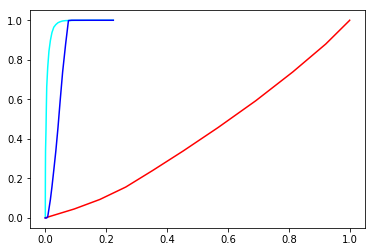

In [50]:
fig,ax = plt.subplots(1,1)
ax.plot(cumsub_siga_green_y, cumsum_sigb_green_y,  color="cyan", linestyle="-");
ax.plot(cumsum_sigb_red_y, cumsum_siga_red_y,  color="red", linestyle="-");
ax.plot(cumsub_siga_green_y, cumsum_siga_red_y,  color="blue", linestyle="-");

# ax[1,0].plot(histx(bins), cumsub_siga_green_y,  color="magenta", linestyle="-" );
# ax[1,0].plot(histx(bins), cumsum_sigb_red_y,  color="cyan", linestyle=":" );
# ax[1,0].plot(histx(bins), cumsum_siga_red_y,  color="magenta", linestyle=":");